In [34]:
from paths import DATASET_IMG, FRONTAL, LATERAL, DATASET_CARS
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import imutils
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [35]:
FRONTALIMAGES = [str(FRONTAL / image_name) for image_name 
                        in os.listdir(FRONTAL)]
    
LATERALIMAGES = [str(LATERAL / image_name) for image_name 
                        in os.listdir(LATERAL)]

In [36]:
def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny
    edged = cv2.Canny(bfilter, 30, 200)
    return img, gray, edged

def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.2
    border_buffer_y = height * 0.2
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
                aspect_ratio = float(w) / h
                if (1.2 < aspect_ratio < 8):
                    good_contours.append(contour)
                    
    good_contours = sorted(good_contours, key=cv2.contourArea, reverse=True)[:200]
    return None if len(good_contours) == 0 else good_contours

def obtain_sift_features(gray_licensplates):
    sift = cv2.SIFT_create()

    #For each image compute their sift features
    sift_features =  list(map(lambda gray_image: sift.detectAndCompute(gray_image, None)[1], gray_licensplates))
    
    # Filter the images that have no sift features. Compress for each image all the sift features found in one row of shape (1, 128)
    sift_features = filter(lambda image_path: image_path is not None, sift_features)
    sift_features = list(map(lambda features: features.sum(0), sift_features))

    sift_features = np.vstack(sift_features)


    return sift_features

### Load classification models

In [37]:
import joblib

svm_clf = joblib.load('svm_model.pkl')
logistic_clf = joblib.load('logistic_model.pkl')

### Qualitative results

In [38]:
def extract_patch_from_image(img, gray, locations):
    cropped_images = []

    for location in (locations):
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        #cropped_image = gray[x1:x2+1, y1:y2+1]
        cropped_image = img[x1:x2+1, y1:y2+1]
        cropped_images.append(cropped_image)
    return cropped_images

# Main method to process the image and visualize the results
def method_3(img_path):
    img, gray, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    cropped_images = extract_patch_from_image(img, gray, locations)
    return cropped_images
    #return img, locations # Returns the contours that SVM needs to classify

#### Test images

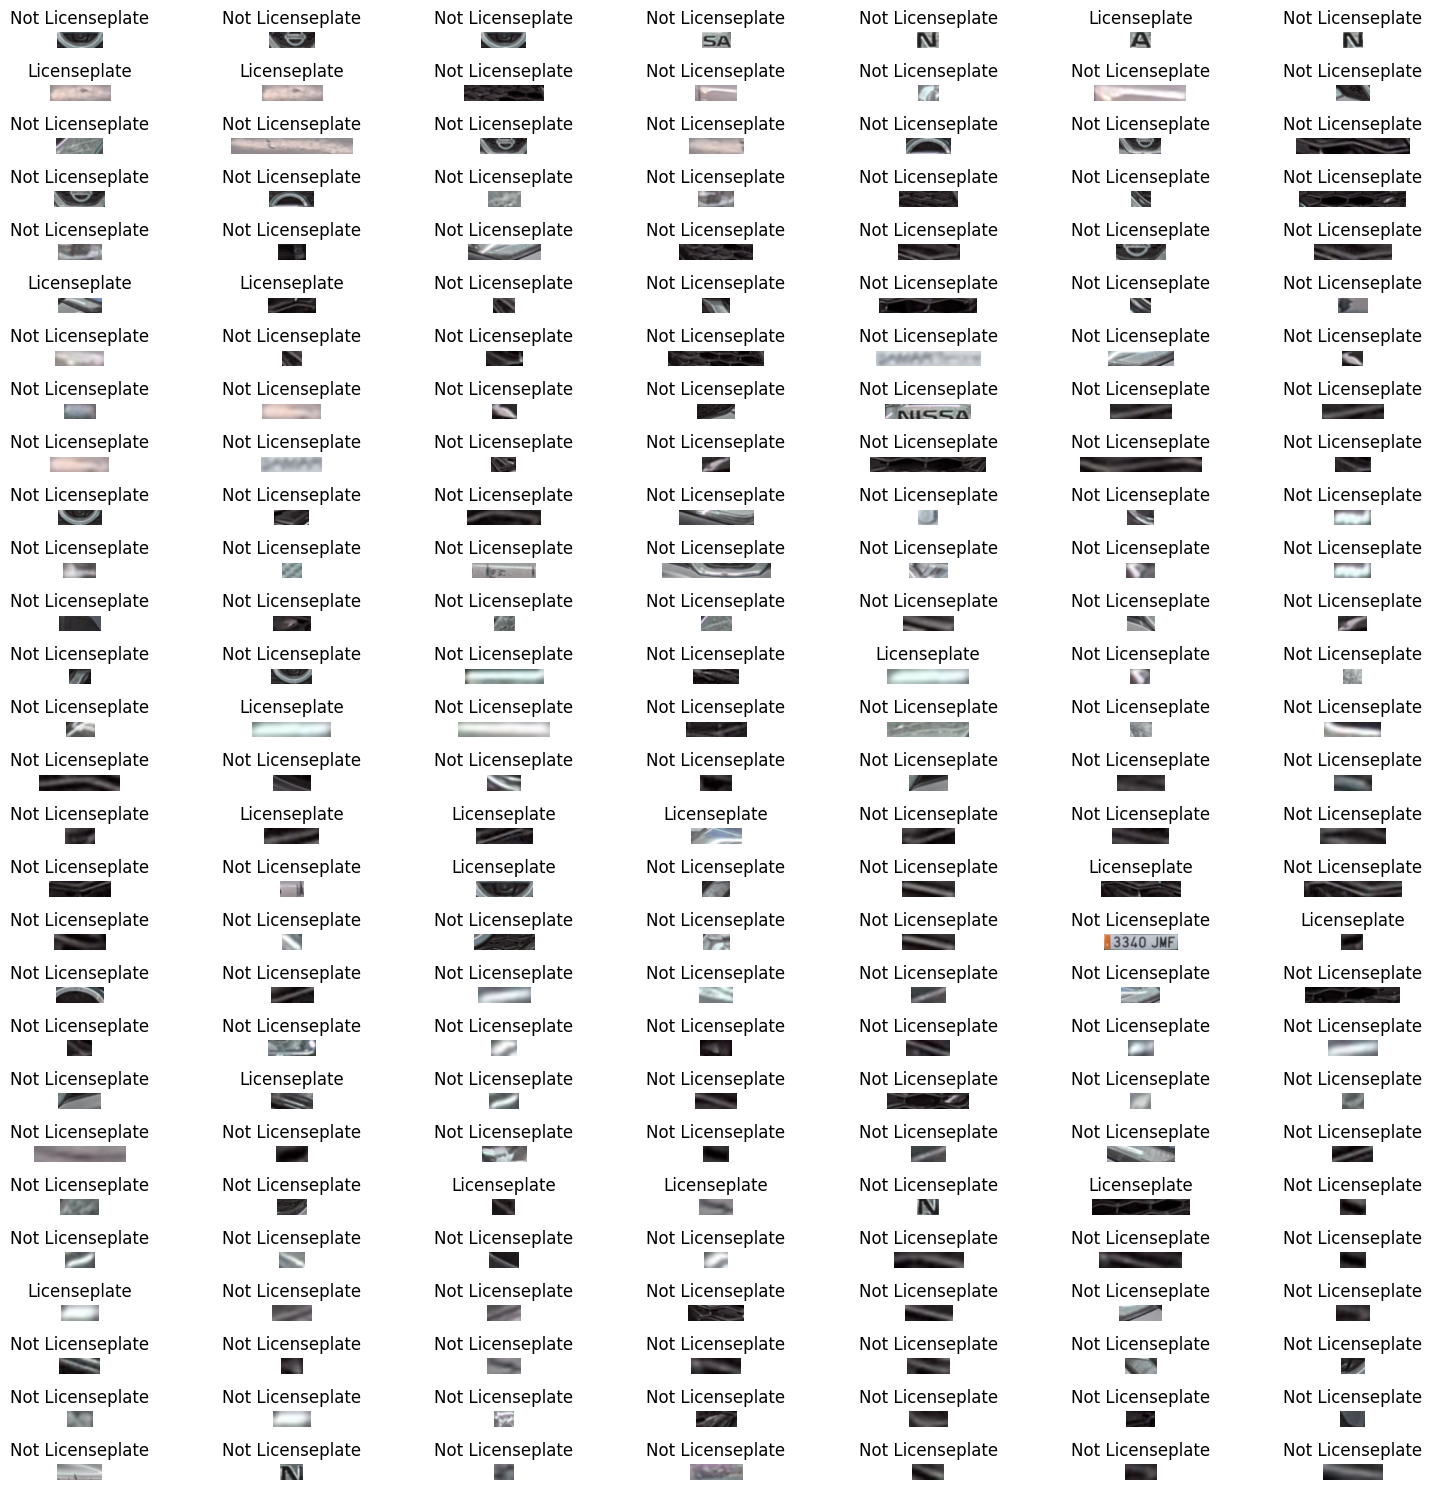

In [39]:
cropped_images = method_3(FRONTALIMAGES[4]) # Well detected frontal: 0 1 2 3 6 9 11 13 14
                                            # Well detected lateral: 0 1 4 5 11
features = obtain_sift_features(cropped_images)

result = logistic_clf.predict(features)
predict_license = np.where(1 == result)[0].tolist()
precit_no_license = np.where(0 == result)[0].tolist()

# Set the figure size to make subplots larger
fig = plt.figure(figsize=(15, 15))

# Create a 10x10 grid of subplots
for i, image in enumerate(cropped_images):
    if (i == (len(cropped_images) // 7) * 7):
        break
    plt.subplot(len(cropped_images) // 7, 7, (i + 1))
    
    if i in predict_license:
        title = "Licenseplate"
    else:
        title = "Not Licenseplate"

    # Adjust the aspect ratio to prevent stretching
    plt.gca().set_aspect('equal', adjustable='box')
    
    # You can adjust the size of the image by setting the interpolation
    plt.imshow(image, cmap='gray', interpolation='bicubic')
    
    plt.title(title)
    plt.axis('off')  # Optional: Hide axis labels

plt.tight_layout()
plt.show()

In [40]:
#pipeline = keras_ocr.pipeline.Pipeline()
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [41]:
def plot_predicted_license(predict_license):
    fig = plt.figure(figsize=(12, 12))
    # Create a 10x10 grid of subplots
    for i, pred in enumerate(predict_license, start=1):
        plt.subplot(len(predict_license), 4, i)

        # Adjust the aspect ratio to prevent stretching
        plt.gca().set_aspect('equal', adjustable='box')

        # You can adjust the size of the image by setting the interpolation
        plt.imshow(pred, cmap='gray', interpolation='bicubic')

        plt.axis('off')  # Optional: Hide axis labels

    plt.tight_layout()
    plt.show()

In [69]:
def predict_text(image_path):
    # plt.imshow(cv2.imread(image_path))
    # plt.show()
    cropped_images = method_3(image_path)
    features = obtain_sift_features(cropped_images)

    result = logistic_clf.predict(features)
    predict_license = np.where(1 == result)[0].tolist()

    predicted_immages = [cropped_images[idx] for idx in predict_license]
    #plot_predicted_license(predicted_immages)
    license_texts = []
    for img in predicted_immages:
        results = reader.readtext(img, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        texts = [result[1] for result in results]
        if len(texts) == 0:
            continue
        license_texts.append(' '.join(texts))

    if len(license_texts) > 0:
        return license_texts[0]
    else: return None

In [76]:
from os import walk

total_frontal_images = len(FRONTALIMAGES)
total_lateral_images = len(LATERALIMAGES)
correct_frontal_images = 0
correct_lateral_images = 0

# print('---------FRONTAL----------')

for (dirpath, dirnames, filenames) in walk(FRONTAL):
    for idx, image in enumerate(filenames):
        license_plate = filenames[idx][:-4]
        text = predict_text(FRONTALIMAGES[idx])
        # print(license_plate)
        # print(text)
        if text is not None and license_plate in text:
            correct_frontal_images += 1
            # print('CORRECT!')
            
# print('---------LATERAL----------')
            
for (dirpath, dirnames, filenames) in walk(LATERAL):
    for idx, image in enumerate(filenames):
        license_plate = filenames[idx][:-4]
        text = predict_text(LATERALIMAGES[idx])
        # print(license_plate)
        # print(text)
        if text is not None and license_plate in text:
            correct_lateral_images += 1
            # print('CORRECT!')

---------FRONTAL----------
1062FNT
E 1062FNT
CORRECT!
1565HTS
E 1565HTS
CORRECT!
2153GYX
E 21536YX
2929KXJ
2929KXJ
CORRECT!
3340JMF
None
3587DCX
None
4674FHC
E L67LFHC
5275HGY
None
5488LKV
None
5796DKP
E 5796 DKP
7067KSH
None
7153JWD
E 7153JHD
8727JTC
None
9247CZG
E 9247 CZG
9892JFR
E 9892JFR
CORRECT!
---------LATERAL----------
0182GLK
E 0182GLK
CORRECT!
0907JRF
JRF 0907
1498JBZ
None
1556GMZ
None
2344KJP
2344KJP
CORRECT!
3044JMB
3044
3587DCX
None
3660CRT
TD
4674FHC
None
5275HGY
None
5789JHB
None
5796DKP
E 5796 DKP
6000GVT
None
6401JBX
None
6554BNX
None
6929LKK
JLKK
8727JTC
E JTC 8727


In [77]:
print('Score is calculated in the following way: \"TOTAL_IMAGES\" / \"CORRECT_DETECTED_IMAGES\"')

print(f'Accuracy score on frontal images: {float(correct_frontal_images/total_frontal_images)}%')
print(f'Accuracy score on lateral images: {float(correct_lateral_images/total_lateral_images)}%')
print(f'Total accuracy score: {float((correct_frontal_images+correct_lateral_images)/total_frontal_images/total_lateral_images)}%')

Score is calculated in the following way: "TOTAL_IMAGES" / "CORRECT_DETECTED_IMAGES"
Accuracy score on frontal images: 0.26666666666666666%
Accuracy score on lateral images: 0.11764705882352941%
Total accuracy score: 0.023529411764705882%
